In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [2]:
dataset = pd.read_json("../Datasets/Sarcasm_Headlines_Dataset.json", lines=True)
dataset.head()

In [3]:
column_name_to_remove = 'article_link'
dataset = dataset.drop(columns=[column_name_to_remove])

dataset.head()

,headline,is_sarcastic
0,washington teen broke up with girlfriend befor...,0
1,new yorkers dismayed at election results can s...,0
2,what your movements may reveal about how you'l...,0
3,alec baldwin's trump impression is apparently ...,0
4,excited firefighters point out kid on tricycle,1


In [4]:
import pandas as pd

# Read the dataset
#dataset = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)

# Get the number of rows in the dataset
num_rows = dataset.shape[0]

# Display the total number of rows
print("Total number of rows in the dataset:", num_rows)


Total number of rows in the dataset: 13354


In [5]:
import pandas as pd

# Read the dataset
#dataset = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)

# Assuming "is_sarcastic" is the column you're interested in
sarcastic_counts = dataset['is_sarcastic'].value_counts()

# Display the result
print("Number of rows for each value in the 'is_sarcastic' column:")
print(sarcastic_counts)



Number of rows for each value in the 'is_sarcastic' column:
is_sarcastic
0    7496
1    5858
Name: count, dtype: int64


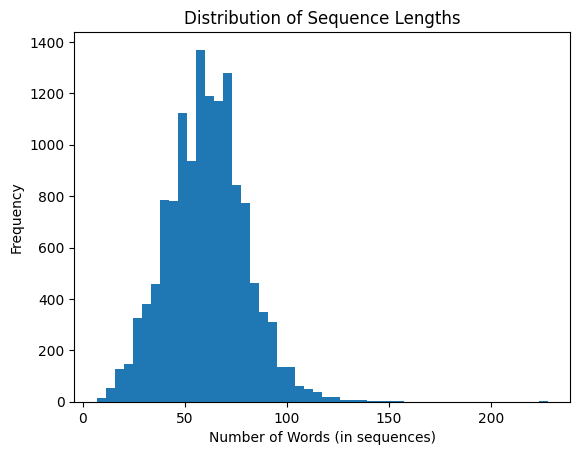

In [6]:
import matplotlib.pyplot as plt

text_data = dataset['headline']

# Calculate sentence lengths
sentence_lengths = [len(sequence) for sequence in text_data]

# Plot histogram
plt.hist(sentence_lengths, bins=50)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of Words (in sequences)')
plt.ylabel('Frequency')
plt.show()

In [7]:
import numpy as np

# Calculate the 95th percentile
max_length_percentile = int(np.percentile(sentence_lengths, 95))
print(f"95th Percentile: {max_length_percentile}")


95th Percentile: 92


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Read the dataset
#dataset = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['headline'], dataset['is_sarcastic'], test_size=0.2, random_state=42)

# Tokenize and vectorize the training text data using Tokenizer and pad_sequences
max_length = 92
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length)

y_train_categorical = to_categorical(y_train, num_classes=2)

# Display the shapes of the resulting matrices
print("Shape of X_train:", X_train.shape)
print("Shape of y_train_categorical:", y_train_categorical.shape)

# Tokenize and vectorize the testing text data using the same Tokenizer
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length)

# Display the shape of X_test
print("Shape of X_test:", X_test.shape)


Shape of X_train: (10683, 92)
Shape of y_train_categorical: (10683, 2)
Shape of X_test: (2671, 92)


In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

embedding_dim = 100

# Define the vocabulary size based on the actual number of unique words in the training data
vocab_size = len(tokenizer.word_index) + 1

max_length = 92

m1 = Sequential()
m1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
m1.add(LSTM(units=150, dropout=0.3, recurrent_dropout=0.3))
m1.add(Dense(units=1, activation='sigmoid'))  # For binary classification
# If you have multiclass classification with three classes, change 'units' to 3 and use 'softmax' activation
# m1.add(Dense(units=3, activation='softmax'))

m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 92, 100)           1855600   
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 2,006,351
Trainable params: 2,006,351
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train the model
m1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = m1.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
 56/167 [=========>....................] - ETA: 54s - loss: 0.6326 - accuracy: 0.6074

KeyboardInterrupt: 

In [12]:
from sklearn.metrics import precision_score, recall_score

# Predict on validation data
y_val_pred_prob_m1 = m1.predict(X_test)
y_val_pred_m1 = (y_val_pred_prob_m1 > 0.5).astype(int)  # Threshold for binary classification

# Assuming y_test is in binary format (0 or 1)
y_val_true_m1 = y_test

# Calculate precision and recall for binary classification
precision_m1 = precision_score(y_val_true_m1, y_val_pred_m1)
recall_m1 = recall_score(y_val_true_m1, y_val_pred_m1)

# print the results
print(f'Precision: {precision_m1:.4f}')
print(f'Recall: {recall_m1:.4f}')

179/179 [==============================] - 16s 89ms/step
Precision: 0.8496
Recall: 0.8215


In [13]:
# Function to preprocess user input and make a prediction
def predict_sarcasm(user_input, model, tokenizer, max_length, threshold=0.5):
    # Tokenize and preprocess user input
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    user_input_padded = pad_sequences(user_input_sequence, maxlen=max_length)

    # Make prediction
    prediction_prob = model.predict(user_input_padded)
    predicted_label = 1 if prediction_prob[0, 0] > threshold else 0

    return predicted_label, prediction_prob

# Example usage:
user_input = input("Enter a sentence: ")

# Call the predict_sarcasm function with a custom threshold (e.g., 0.3)
predicted_label, predicted_prob = predict_sarcasm(user_input, m1, tokenizer, max_length, threshold=0.3)

# Display the prediction
if predicted_label == 1:
    print("The model predicts that the input is sarcastic.")
else:
    print("The model predicts that the input is not sarcastic.")

# Optional: Display the predicted probabilities
print("Predicted Probabilities:", predicted_prob)
print("User input", user_input)


1/1 [==============================] - 0s 241ms/step
The model predicts that the input is sarcastic.
Predicted Probabilities: [[0.51362354]]
User input That is crazy


In [14]:
import pickle

with open('model_pickle','wb') as file:
    pickle.dump(m1,file)

INFO:tensorflow:Assets written to: ram://580b8f51-408f-45bf-a6ff-7da6f3a3e1c9/assets


In [15]:
import pickle
#testing out pickled model
with open('model_pickle','rb') as file:
    mp = pickle.load(file)


# Example usage:
user_input = input("Enter a sentence: ")


# Call the predict_sarcasm function with a custom threshold (e.g., 0.3)
predicted_label, predicted_prob = predict_sarcasm(user_input, mp, tokenizer, max_length, threshold=0.3)

# Display the prediction
if predicted_label == 1:
    print("The model predicts that the input is sarcastic.")
else:
    print("The model predicts that the input is not sarcastic.")

# Optional: Display the predicted probabilities
print("Predicted Probabilities:", predicted_prob)
print("User input", user_input)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://e2f603d1-7120-4e78-a4b3-0cd39af6e0c8/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.